In [0]:
#Authenticate
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import numpy as np
import pandas as pd

Data for this dating profile is available at www.libimseti.cz - Dating website recommendation (collaborative filtering) http://www.occamslab.com/petricek/data/ 


Indian Matrimonial DataSet at http://iacs-courses.seas.harvard.edu/courses/iacs_projects/matrimony_data_exploration/introduction.html. You may want to look at the dataset. This dataset is huge, so many csv's.
https://github.com/deadofied/ac299r/tree/master/data

In [0]:
#dataset_id - 17FCZe4aPSTepWZrt6CwbFNoe0xU9wXi5
dataset_downloaded = drive.CreateFile({'id':'17FCZe4aPSTepWZrt6CwbFNoe0xU9wXi5'})
dataset_downloaded.GetContentFile('ratings.csv')
columns= ['UserID','ProfileID','Rating']
df_dating = pd.read_csv('ratings.csv',names = columns)

In [9]:
df_dating.head()

,UserID,ProfileID,Rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [12]:
df_dating.shape

(17359346, 3)

In [13]:
df_dating['UserID'].nunique(), df_dating['ProfileID'].nunique()

(135359, 168791)

In [0]:
# Making another dataframe in which sampling will be done; in order to preserve the original.
df_dating_beta = df_dating.copy()

In [0]:
#ttps://drive.google.com/open?id=1XJKFEpMvXJOzkcxZgncLGJoHWr7bE7m-
dataset_downloaded = drive.CreateFile({'id':'1XJKFEpMvXJOzkcxZgncLGJoHWr7bE7m-'})
dataset_downloaded.GetContentFile('gender.csv')
columns= ['Gender']
df_gender = pd.read_csv('gender.csv',names = columns)

In [16]:
df_gender.head()

,Gender
1,F
2,F
3,U
4,F
5,F


In [17]:
df_gender.shape

(220970, 1)

In [18]:
df_gender['Gender'].value_counts()

U    83164
M    76441
F    61365
Name: Gender, dtype: int64

In [0]:
profile_mean_rating = pd.DataFrame(df_dating.groupby('ProfileID')['Rating'].mean())

In [0]:
user_mean_rating =pd.DataFrame(df_dating.groupby('UserID')['Rating'].mean())

In [0]:
profile_mean_rating['number of rating'] = pd.DataFrame(df_dating.groupby('ProfileID')['Rating'].count())

In [0]:
user_mean_rating['number of rating'] = pd.DataFrame(df_dating.groupby('UserID')['Rating'].count())

In [0]:
user_new_meanrate = user_mean_rating[user_mean_rating['number of rating'] > 300]

In [0]:
user_index = user_new_meanrate.index

In [0]:
profile_new_meanrate = profile_mean_rating[profile_mean_rating['number of rating'] > 300 ]

In [0]:
profile_index = profile_new_meanrate.index

In [33]:
type(profile_index)

pandas.core.indexes.numeric.Int64Index

In [0]:
df_dating_sample = df_dating.loc[(df_dating['UserID'].isin(user_index)) & (df_dating['ProfileID'].isin(profile_index))]

In [35]:
df_dating_sample.shape

(3465704, 3)

In [36]:
df_dating_sample['UserID'].nunique(), df_dating_sample['ProfileID'].nunique()

(8130, 12458)

In [37]:
df_dating_sample.head()

,UserID,ProfileID,Rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [38]:
profile_mean_rating.head()

,Rating,number of rating
ProfileID,,
1,5.272727,22
2,7.150235,213
4,1.000000,1
8,7.500000,4
9,9.454545,22


In [39]:
df_dating_sample.head()

,UserID,ProfileID,Rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [0]:
profile_mean_rating = pd.DataFrame(df_dating_sample.groupby('ProfileID')['Rating'].mean())
profile_mean_rating['number of rating'] = pd.DataFrame(df_dating_sample.groupby('ProfileID')['Rating'].count())
user_mean_rating =pd.DataFrame(df_dating_sample.groupby('UserID')['Rating'].mean())
user_mean_rating['number of rating'] = pd.DataFrame(df_dating_sample.groupby('UserID')['Rating'].count())


# Visulaizing the Profile rating dataset to undersatnd how the profile are rated and top profiles

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

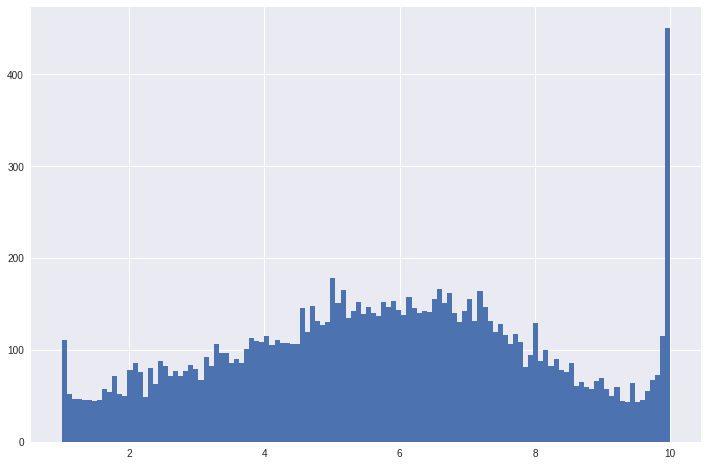

In [42]:
plt.figure(figsize=(12,8))
profile_mean_rating['Rating'].hist(bins=120)

**In the above plot we see the graph follows a normal distribution except at the peaks ratings 1 and 10 which tells us that there are a lot of profile which are not liked by many user and lots of profiles heavily liked by users.**

In [43]:
profile_mean_rating['number of rating'].sort_values(ascending=False).head()


ProfileID
68989     4450
179192    4209
83773     4160
155380    3667
50408     3587
Name: number of rating, dtype: int64

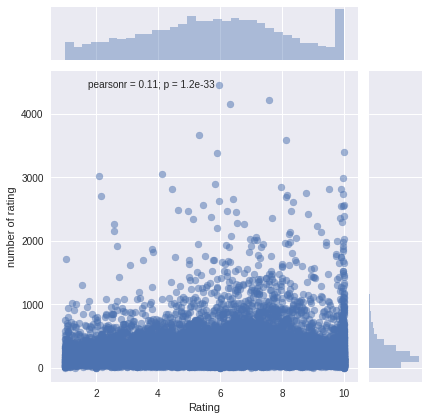

In [44]:
sns.jointplot(x='Rating',y='number of rating',data=profile_mean_rating,alpha=0.5)

**We can see that for profiles around 6 to 8 is rated most and also number of profiles which are rated 10 is quite large in number. This indicates that most people rate the profile they like.**

**Plan of action for this week:**

**1.Popularity based recommendation
2.Content based recommendation
3.User-User Recommendation
4.Item-Item Recommendation
5.SVD(without applying SGD to improve the weights)**

In [45]:
#Popularity based recommendation will recommend top 10 profiles which are rated by most number of user and are greater than 9.

#Just writing the code snippet before putting the code in function
  
df_profile = profile_mean_rating.sort_values(['number of rating','Rating'],ascending=[False,False])
df_profile.head()

,Rating,number of rating
ProfileID,,
68989,5.972809,4450
179192,7.569494,4209
83773,6.311538,4160
155380,5.334333,3667
50408,8.135768,3587


In [46]:
len(profile_mean_rating[(profile_mean_rating['number of rating'] > 10000) & (profile_mean_rating['Rating'] > 9)])

0

In [0]:
#Defining Popularity Based Model
def popular_recommend_model(userID,profile_df,threshold,k):
  """
  It will return top 'k' profiles based on highest rating and number of ratings greated than the defined threshold irrespective of User ID,
  If value of K is greater than the number of profile which matches the given criteria, then it is just going to return maximum profile 
  matching the given criteria.
  """
 # try:
#   if len(profile_df[(profile_df['number of rating'] > threshold) & (profile_df['Rating'] > 9)]) < 1:
#     print("Your filtering doesn't match any profiles")
  return (profile_df[(profile_df['number of rating'] > threshold) & (profile_df['Rating'] > 9)].head(k).index)
 # except:
 #   print("Index out of range")

In [48]:
popular_recommend_model(123,profile_mean_rating,2500,10)

Int64Index([14258, 22319, 61157, 65602, 75169, 98678, 156148, 159680], dtype='int64', name='ProfileID')

In [0]:
#2. Content- Based Recommendation
#It will check the similarity of profiles based on different latent features and recommend profile similar to the that profiles based on user 
#previous profile rating
#creating Profile Matrix which will hold user as index and profile as column and their rating as values
profilemat = df_dating_sample.pivot_table(index='UserID',columns='ProfileID',values='Rating')

In [50]:
profilemat.index

Int64Index([     1,      9,     31,     65,     73,     99,    128,    134,
               141,    147,
            ...
            135253, 135273, 135280, 135281, 135285, 135298, 135334, 135337,
            135350, 135357],
           dtype='int64', name='UserID', length=8130)

In [51]:
profilemat.head()

ProfileID,42,55,57,58,77,84,90,132,133,175,...,220760,220782,220788,220840,220848,220859,220861,220900,220950,220953
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can take users in df_dating with ratings grator than 19, Let's see than also ram gets full or not.

**Now le's suppose some onle likes profiles 55, whatelse could we recommend to that user, 
so we find similarity of other profiles with the profile 55 , this is considered as content based filtering. **

In [52]:
profile55_ratings = profilemat[55]
profile55_ratings.head()

UserID
1     NaN
9     5.0
31    NaN
65    NaN
73    NaN
Name: 55, dtype: float64

In [53]:
similarto_profile55 = profilemat.corrwith(profile55_ratings)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [54]:
similarto_profile55.head()

ProfileID
42   -0.474675
55    1.000000
57    0.074370
58   -0.866025
77    1.000000
dtype: float64

In [55]:
corr_profile55 = pd.DataFrame(similarto_profile55,columns=['Correlation'])
corr_profile55.dropna(inplace=True)
corr_profile55.head()

,Correlation
ProfileID,
42,-0.474675
55,1.000000
57,0.074370
58,-0.866025
77,1.000000


In [56]:
corr_profile55.sort_values('Correlation',ascending=False).head(10)

,Correlation
ProfileID,
26225,1.0
215226,1.0
9081,1.0
93818,1.0
189404,1.0
161416,1.0
62012,1.0
161843,1.0
21246,1.0


**Here we see multiple profile are perfectly correlated, one reason could be only 1 or 2 user had rated that profile and those rating matched. So to give more relevant profile, we need to filter out based on certain number of users who have rated those profiles and still if those are similar then we will recommend those.**

In [57]:
corr_profile55 = corr_profile55.join(profile_mean_rating['number of rating'])
corr_profile55.head()

,Correlation,number of rating
ProfileID,,
42,-0.474675,32
55,1.000000,497
57,0.074370,205
58,-0.866025,80
77,1.000000,84


In [58]:
corr_profile55[corr_profile55['number of rating'] >300].sort_values('Correlation',ascending = False).head(10)

,Correlation,number of rating
ProfileID,,
55,1.000000,497
67445,1.000000,448
34045,1.000000,307
186261,1.000000,433
74924,0.981981,391
206226,0.902829,468
149957,0.890871,317
165712,0.805823,321
101142,0.803886,390


**Putting all these in a function which will take any profile ID and return most similar profile to that profile given the profile has atleast 200 ratings**

In [0]:
def content_based_recommend(profileID, profilemat,profile_mean_rating):
  """
  This function which will take any profile ID and return most similar profile to that profile from user-profile rating matrix
  given the profile has atleast 200 ratings
  """
  rating_profileID = profilemat[profileID]
  corr_profileID = pd.DataFrame(profilemat.corrwith(rating_profileID),columns=['Correlation'])
  corr_profileID.dropna(inplace=True)
  corr_profileID = corr_profileID.join(profile_mean_rating['number of rating'])
  return (corr_profileID[corr_profileID['number of rating'] > 300].sort_values('Correlation',ascending=False).head(20))

In [60]:
content_based_recommend(175,profilemat,profile_mean_rating)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,Correlation,number of rating
ProfileID,,
8088,1.0,469
48577,1.0,461
88862,1.0,532
121890,1.0,469
7778,1.0,404
121273,1.0,419
7965,1.0,817
119551,1.0,357
9306,1.0,894


For User-item or item-item memory based Collaborative Filetering, we need to make a matrix in which we'll be storing the pairwise distance;  Also do we need to split our dataset into train and test set? Because in which we'll be storing the distance right?
We'll be applying this  right?
<br> <h3> For item-item <br>
  <p> Cosine Similarity </p>
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

User -Item Similarity : Users who are similar to you also liked

Similarity values between users are measured by observing all the items that are rated by both users.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>



In [0]:
from sklearn.model_selection import train_test_split

In [0]:
df_train, df_test = train_test_split(df_dating, test_size = 0.25)

In [67]:
n_users_all = df_dating['UserID'].unique().shape[0]
n_items_all = df_dating['ProfileID'].unique().shape[0]
n_users_all, n_items_all

(135359, 168791)

In [68]:
n_users = df_dating_sample['UserID'].unique().shape[0]
n_items = df_dating_sample['ProfileID'].unique().shape[0]
n_users, n_items

(8130, 12458)

(8130, 12436)

In [69]:
df_dating_sample['ProfileID'].unique().shape[0]

12458

In [70]:
df_dating_sample.shape, df_train.shape, df_test.shape

((3465704, 3), (2599278, 3), (866426, 3))

In [140]:
for line in df_dating_sample.itertuples():
  print(line)
  break

Pandas(Index=0, UserID=1, ProfileID=133, Rating=8)


In [0]:
train_data_mat = np.zeros((n_users, n_items))

In [0]:
#Create two user-item matrix, one for training and another for testing
train_data_mat = np.zeros((n_users, n_items))
#itertuples gives you content of the row along with it's index
for line in df_train.itertuples():
  #line[1] - 1 is used to account for index to start from 0, so we get value like
  #train_data_mat[userID,ProfileID] = Rating
  train_data_mat[ line[1] -1, line[2] -1 ] = line[3]
test_data_mat = np.zeros((n_users, n_items))
for line in df_test.itertuples():

  test_data_mat[ line[1] -1, line[2] -1 ] = line[3]


In recommendation system, we commonly use cosine matrix which will treat the ratings given by a specific user as a vector assuming all the null values as 0 rating and then the cosine gives you the measure of similarity as we know cos(0) = 1 so a value of 1 means the users are very similar.

Cosine similiarity for users *a* and *m* can be calculated using the formula below, where you take dot product of  the user vector *$u_k$* and the user vector *$u_a$* and divide it by multiplication of the Euclidean lengths of the vectors.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>


To calculate similarity between items *m* and *b* you use the formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>


In [0]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

Now we will make prediction based on the similarity of the above calculated matrix. For user based CF, we will use the below formula.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

We are subtracting the user mean rating from each rating which would take care of differences between user while rating. Say for example, a user m rates good profile with 8 and the profile he dislikes with 2 and similarly other user a rates movies he likes with 10 and other movies 4. Now both the users have similar taste but they rate differently. After removing the average rating of a user, we also need to normalize so the rating doesn't cross 10. For this we have divided with the 

And for item based CF, we will use the below mentioned formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [0]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        rate_pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        rate_pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return rate_pred

In [0]:
item_prediction = predict(train_data_mat, item_similarity, type='item')
user_prediction = predict(train_data_mat, user_similarity, type='user')

We will use RMSE to evaluate the predicted ratings.

Now for calculating RMSE , we would like to filter out the rating which re available in the test_data_mat. This could be done by using nonzero method on the series which would provide the index were the values are not zero.

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, test):
    prediction = prediction[test.nonzero()].flatten() 
    test = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, test))

In [0]:
print('User-Item similarity CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-Item similarity CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

**Model Based Collaborative Filtering**

Model based collaborative filtering is based on Matrix Factorisation which is a unsupervised learning. The goal of factorisation is to find the latent features of Users and Latent features of items.

Matrix factorization models map both users and items to a joint latent factor space of dimensionality, such that user-item interactions are modeled as inner products in that space. Accordingly, each item i is associated with avector qi ∈ train_data_mat(User-Item rating matrix), and each user u is associated with a vector pu ∈ train_data_mat(User-Item rating matrix) .

For a given item i, the elements of qi measure the extent to which the item possesses those factors, positive or negative. For a given user u, the elements of pu measure the extent of interest the user has in items that are high on the corresponding factors, again, positive or negative. The resulting dot product,
qi.T.pu
 captures the interaction between user u and item i—the user’s overall interest in the item’s characteristics. This approximates user u’s rating of item i, which is denoted by rui, leading to the estimate
rˆui = qi.T .pu.

**SVD**
A well known method for Matrix Factorisation is Singular Value Decomposition(SVD). The general equation for SVD is expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?M=USV^T" title="M=USV^T" />

Given `m x n` matrix `M`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Elements on the diagnoal in `S` are known as *singular values of `M`*. 


Matrix *`M`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space.

In [0]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_mat, k = 50)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('Model-based CF MSE: ' + str(rmse(X_pred, test_data_mat)))